# Inducible Repression with Multiple Promoters

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [ ]:

def fugacity(R, M, N, ep, pact_args):
    p_act = pact(**pact_args)
    ra = p_act * R
    x = np.exp(-ep)  
    y = 1
    A = (ra*x + ra*y - M * x - N * y) / (2*(ra*x*y - M*x*y - N*x*y))
    B_numer = np.sqrt((ra*x + ra*y - M*x - N * y)**2 - 4 * ra* (ra * x * y - M * x * y - N * x *y))
    B_denom = 2*(ra*x*y - M * x * y - N * x *y)
    B = B_numer / B_denom
    fug1 = -A + B
    fug2 = -A - B
    return 1/ (1 + fug2 * np.exp(-ep))

In [676]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.viz
import bokeh.io
import bokeh.plotting
import bokeh.models
from bokeh import events
from bokeh.models import ColumnDataSource, Div, CustomJS, CDSView, IndexFilter
from bokeh.layouts import layout, widgetbox
from bokeh.models.widgets import Select, Slider, RadioButtonGroup, Button
constants = mut.thermo.load_constants()
colors = mut.viz.color_selector('pboc')
import pystan
from mpl_toolkits.mplot3d import Axes3D
mut.viz.plotting_style()
bokeh.io.output_notebook()
%load_ext stanmagic

Loading BokehJS ...

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


The goal of this notebook is to examine the influence of multiple promoter copy numbers on inducible simple repression. THis sparked from discussionw with Rob an Phillips and Mitch Lewis with respect to datasets with differing values for the various parameters.

The following derivations and discussions stem primarily from Rob's notes directly. 

## Case I: Single-site inducible repression 

Imagine that we have a *single* operator sequence regulating the expression of some gene $X$. Given knowledge of the number of *active* repressors per cell, we can mathematically state the fold-change in gene expression as

$$
\text{fold-change} = {1 \over 1 + {R_A \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}}}
\tag{1}
$$,

where $R_A$ is the number of active repressors, $N_{NS}$ is the number of nonspecific binding sties, and $\Delta\varepsilon_{RA}$  is the binding energy of the active repressor to the binding site. If we only know the *total* number of repressors, we can compute the probability that one of them will be active at a a given inducer concentration $c$,

$$
p_\text{act}(c) = {1 \over 1 + e^{-\beta\Delta\varepsilon_{AI}}\left({1 + {c \over K_I} \over 1 + {c \over K_A}}\right)^n}.
\tag{2}
$$

Here, $K_A$ and $K_I$ are the inducer dissociation constants to the active and inactive repressor and $\Delta\varepsilon_{AI}$ is the relative energetic differnece between the active and inactive repressor states. With the powers of Eq. 1 and Eq. 2 combined, we can write the total fold-change in gene expression as 

$$
\text{fold-change} = {1 \over 1 + p_\text{act}(c) {R \over N_{NS}}e^{-\beta\Delta\varepsilon_{RA}}}
\tag{3}
$$
where $R$ is the total number of repressors per cell. 

##  Case II: Multiple Promoter Copies

Things get more difficult to think about in this case. Consider that we again have $R$ repressors abut now with $M$ copies of the promoter which is regulated. If $R \approx M$ or $M > R$, then it is impossible to completely repress expression as there are more gene copies than regulatory molecules. As a consequence, the fold-change curve is very different and includes the *tepressor fugacity*,

$$
\text{fold-change} = {1 \over 1 + \lambda_R(c) e^{-\beta\Delta\varepsilon_{RA}}}
\tag{4}
$$

where the fugacity $\lambda_R$ is given as

$$
\lambda_R(c) = e^{-\beta \mu} = {-[p_\text{act}(c)R(e^{-\beta\varepsilon_S} + e^{-\beta\varepsilon_{NS}}) - Me^{-\beta\Delta\varepsilon_S} - Ne^{-\beta\varepsilon_{NS}}] \over 2e^{-\beta\Delta\varepsilon_{RA}}(p_\text{act}(c)R - M - N)} \pm {\sqrt{[p_\text{act}R(e^{-\beta\varepsilon_S} + e^{-\beta\varepsilon_{NS}}) - M(e^{-\beta\varepsilon_S} + e^{-\beta\varepsilon_{NS}})^2 - 4p_\text{act}Re^{-\beta\Delta\varepsilon_{RA}}\left(p_\text{act}(c)R - M - N\right)} \over 2e^{-\beta\Delta\varepsilon_{RA}}(R - M - N)}.
\tag{5}
$$


Now that is super disgusting! But it should be able to capture the phenomenology of the induction profiles


### Plotting induction profiles

In [519]:
def pact(c, ep, ka, ki):
    numer = (1 + c / ka)**2
    denom = numer + np.exp(-ep) * (1 + c/ki)**2
    return numer / denom

def fugacity(R, M, N, ep, pact_args):
    p_act = pact(**pact_args)
    ra = p_act * R
    x = np.exp(-ep)  
    y = 1
    A = (ra*x + ra*y - M * x - N * y) / (2*(ra*x*y - M*x*y - N*x*y))
    B_numer = np.sqrt((ra*x + ra*y - M*x - N * y)**2 - 4 * ra* (ra * x * y - M * x * y - N * x *y))
    B_denom = 2*(ra*x*y - M * x * y - N * x *y)
    B = B_numer / B_denom
    fug1 = -A + B
    fug2 = -A - B
    return 1/ (1 + fug2 * np.exp(-ep))

In [520]:
r_range = np.logspace(0, 3, 500)
c_range = np.logspace(-2, 4, 500)
# c_range = np.zeros_like(c_range)
M = 1000
N = 4.6E6
ep_s = -15 # k_BT
r, c = np.meshgrid(r_range, c_range)

In [521]:
_fug = fugacity(r, M, N, ep_s, {'c':c, 'ep':4.5, 'ka':139, 'ki':0.53})

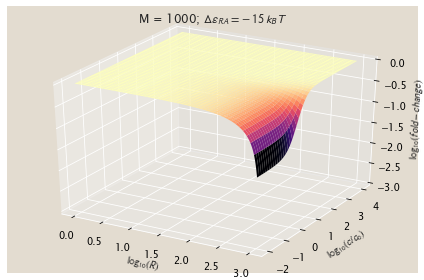

In [522]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log10(r), np.log10(c), np.log10(_fug), cmap='magma', lw=0)
ax.set_xlabel('$\log_{10}(R)$')
ax.set_ylabel('$\log_{10}(c/c_0)$')
ax.set_zlabel('$\log_{10}(fold-change)$')
ax.set_title(f'M = {M}' + r'; $\Delta\varepsilon_{RA}=%s\,k_BT$' %ep_s)
ax.set_zlim([-3, 0])
plt.tight_layout()
plt.savefig(f'./M{M}_epRA{ep_s}_surface.svg', transparent=True, bbox_inches='tight')

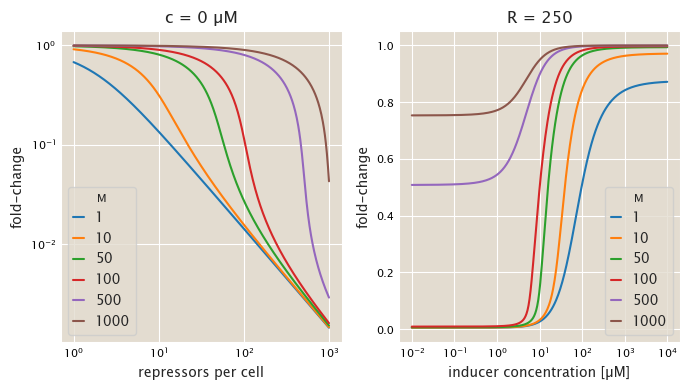

In [584]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4), dpi=100)
for a in ax:
    a.xaxis.set_tick_params(labelsize=8)
    a.yaxis.set_tick_params(labelsize=8)
M_vals = [1, 10, 50, 100, 500, 1000]
for m in M_vals:
    _fug = fugacity(r_range, m, N, ep_s, {'c':0, 'ep':4.5, 'ka':139, 'ki':0.53})
    ax[0].loglog(r_range, _fug, '-', label=int(m))
    
for m in M_vals:
    _fug = fugacity(250, m, N, ep_s, {'c':c_range, 'ep':4.5, 'ka':139, 'ki':0.53})
    ax[1].semilogx(c_range, _fug, '-', label=int(m))
    
leg = ax[0].legend(title='M', handlelength=0.75)
leg.get_title().set_fontsize(8)
leg = ax[1].legend(title='M', handlelength=0.75)
leg.get_title().set_fontsize(8)

ax[0].set_xlabel('repressors per cell')
ax[1].set_xlabel('inducer concentration [µM]')
ax[0].set_ylabel('fold-change')
ax[1].set_ylabel('fold-change')
ax[0].set_title('c = 0 µM')
ax[1].set_title('R = 250')
plt.tight_layout()
plt.savefig('./fugacity_curves.pdf', bbox_inches='tight')
#     ax[0].loglog(r_range,_fug[10], '--')
#     ax[0].loglog(r_range, _fug[300], ':')

## Applying it to Mitch's data

Well, that certainly proves that we exist on different fold-change curves and we *cannot* use the same functional form for both. Using the parameters infered from the single-site repression data, can we inferr R and M from Mitch's data and have a unified description?

In [655]:
%%stan 
data {
    int<lower=1> N; // Number of points
    int<lower=1> Nns;
    real<lower=0> c[N];// IPTG concentration
    real fc[N]; // Fold-change in gene expression
    real<lower=0> ka;
    real<lower=0> ki;
    real ep_ai;
    real ep_RA;
}


parameters { 
    real<lower=1> R; // Number of repressors per cell
    real<lower=1> M; // Number of plasmids 
    real<lower=0> sigma;
}

model {
    real mu[N];
    real pact[N];
    real fugacity[N];
    real A;
    real B;
    real C;
    R ~ lognormal(3, 3);
    M ~ lognormal(2, 2); 
    sigma ~ normal(0, 1);
    for (i in 1:N) {
        pact[i] = (1 + exp(-ep_ai) * ((1 + c[i]/ki)/(1 + c[i]/ka))^2)^-1;
        A = exp(-ep_RA) * (pact[i] * R - M - Nns) ;
        B = (R * pact[i] * exp(-ep_RA) + R * pact[i] - M * exp(-ep_RA) - Nns);
        fugacity[i] = -B - sqrt(B^2 - 4 * pact[i] * R * A) / (2 * A);
        mu[i] = (1 + fugacity[i] * exp(-ep_RA))^-1; 
    }
        
    fc ~ normal(mu, sigma);
    
}


Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in _stan_model object.
Type _stan_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
_stan_model.model_file -> Name of stan_file [None]
_stan_model.model_name -> Name of stan model [None]
_stan_model.model_code -> Model code [data {     int<lower ....]


In [656]:
model = pystan.StanModel(model_code = _stan_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5758862afc0164019915824c2fd40731 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp56znnyvy/stanfit4anon_model_5758862afc0164019915824c2fd40731_6660016137035357565.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


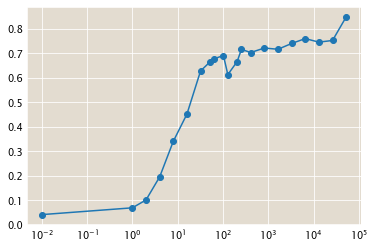

In [657]:
# Load Mitch's data.
data = pd.read_csv('../../data/csv/Daber2011_data.csv')
wt = data[data['mutant']=='wt']

plt.semilogx(wt['IPTGuM'], wt['fold_change'], '-o')

In [658]:
# Load Mitch's data.
data_dict = {'N':len(wt), 'c':wt['IPTGuM'], 'fc':wt['fold_change'],
            'Nns':int(4.6E6), 'ka':constants['Ka'], 'ki':constants['Ki'],
            'ep_ai':4.5, 'ep_RA':constants['O1']}
samples = model.sampling(data_dict, iter=8000, control=dict(adapt_delta=0.95))

In [659]:
samples

Inference for Stan model: anon_model_5758862afc0164019915824c2fd40731.
4 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
R     2165.1  342.33  3.2e4   1.27   7.26  36.33  226.0 8926.2   8621    1.0
M      69.86     4.3 442.16   1.19    3.7   11.2  38.05 429.14  10574    1.0
sigma   0.65  9.7e-4   0.11   0.48   0.57   0.64   0.71   0.89  12061    1.0
lp__   -2.71    0.02   1.29  -6.06   -3.3  -2.38  -1.77  -1.25   5644    1.0

Samples were drawn using NUTS at Mon May 13 17:33:15 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [660]:
samples = samples.to_dataframe()

In [661]:
c_range = np.logspace(-2, 6, 500)
cred_region = np.zeros((len(c_range), 2))
for i, c in enumerate(c_range):
    _fug = fugacity( samples['R'], samples['M'], 4.6E6, constants['O1'], {'c':c, 
                                                              'ka':constants['Ka'], 
                                                              'ki':constants['Ki'],
                                                             'ep':constants['ep_AI']})
    cred_region[i, :] = mut.stats.compute_hpd(_fug, 0.95)

In [662]:
stats = mut.stats.compute_statistics(samples, varnames=['R', 'M'], logprob_name='lp__')
stats['min'] = stats['median'] - stats['hpd_min']
stats['max'] = stats['median'] - stats['hpd_max']
stats
R = stats[stats['parameter']=='R']
M = stats[stats['parameter']=='M']

In [663]:
stats

,parameter,mean,median,mode,hpd_min,hpd_max,min,max
0,R,2165.190387,36.333641,25.324632,1.000558,3594.450666,35.333083,-3558.117024
1,M,69.860979,11.204694,10.594858,1.000625,243.731659,10.204069,-232.526965


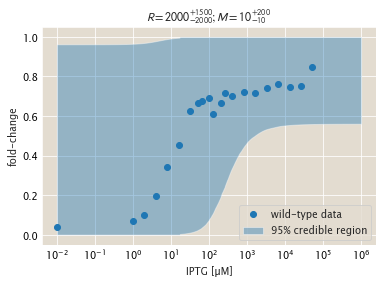

In [669]:
plt.semilogx(wt['IPTGuM'], wt['fold_change'], 'o', label='wild-type data')
plt.fill_between(c_range, cred_region[:, 0], cred_region[:, 1], alpha=0.4, label='95% credible region')
plt.title('$R = 2000_{-2000}^{+1500}; M = 10_{-10}^{+200}$')
plt.xlabel('IPTG [µM]')
plt.ylabel('fold-change')
plt.legend(loc='lower right')
plt.savefig('./fugacity_fit.pdf')

In [665]:
import corner
samples['log10(R)'] = np.log10(samples['R'])
samples['log10(M)'] = np.log10(samples['M'])

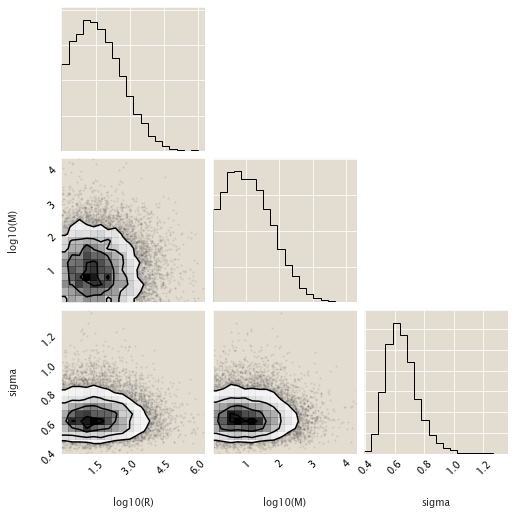

In [666]:
_ = corner.corner(samples[['log10(R)', 'log10(M)', 'sigma']])
plt.savefig('./fit_corner_plot.pdf')

### Building a slider for parameter space exploration

In [714]:
# Define the javascript
js = """
// Define the constants
var  data = source.data;
var c = data['c']
var R = R_slider.value
var M = M_slider.value
var ka = 139;
var ki = 0.53
var ep_ai = 4.5
var n = 2;
var Nns = 46000000;

// Define function to compute the fugacity. 
function computePact(c, ka, ki, ep_ai, n) {
    var numer = Math.pow(1 + c / ki, n);
    var denom = Math.pow(1 + c / ka, n);
    var prob = Math.pow(1 + Math.exp(-ep_ai) * numer / denom, -1);
    return prob;
    }
function computeFoldChange(R, M, pact) {
    var r = R * pact;
    var x = Math.exp(15.3); // Defined value for O1
    var B = (r * (1 + x) - M * x - Nns) 
    var C = r;
    var A = x * (r - M - Nns);
    console.log(B);
    var fugacity = (-B - Math.sqrt(B*B - 4 * A * c)) / (2 * A);
    return Math.pow(1 + fugacity * x, -1); 
    }
    
// Evaluate the fold-change. 
var fc = [];
for (var i = 0; i < c.length; i++) {
   var pact = computePact(c[i], ka, ki, ep_ai, n); 
   fc[i] = computeFoldChange(R, M, pact);
   } 

source.data['fold_change'] = fc;
source.change.emit()
"""

In [721]:
bokeh.plotting.output_file("fugacity_explorer.html")
c_range = np.logspace(-2,6, 500)
p = bokeh.plotting.figure(width=600, height=400, x_axis_type='log',
                         x_axis_label='IPTG [µM]', y_axis_label='fold-change')


# Set up the column data source for the slider.
source = ColumnDataSource(data={'c':c_range, 'fold_change':np.zeros(len(c_range))})
p.circle(wt['IPTGuM'], wt['fold_change'], legend='Wild Type Data', size=8)
p.line(x='c', y='fold_change', source=source, line_width=4, legend='Theory')
p.legend.location = 'bottom_right'

# Define the javascript callback. 
cb = CustomJS(args={'source':source, 'R_slider':R_slider, 'M_slider':M_slider}, code=js)

# Define the sliders
R_slider = Slider(start=1, end=2000, value=1, step=10, title='Repressors per cell')
M_slider = Slider(start=1, end=2000, value=1, step=10, title='Plasmids per cell')

# Set up the widgetbox
R_slider.callback = cb
M_slider.callback = cb
box = widgetbox([R_slider, M_slider])


# Define the layout and show plot
layout = bokeh.layouts.gridplot([[p, box]])
bokeh.io.save(layout)

RuntimeError: Models must be owned by only a single document, CustomJS(id='3688', ...) is already in a doc

In [719]:
bokeh.io.save?

Signature: bokeh.io.save(obj, filename=None, resources=None, title=None, template=None, state=None, **kwargs)
Docstring:
Save an HTML file with the data for the current document.

Will fall back to the default output state (or an explicitly provided
:class:`State` object) for ``filename``, ``resources``, or ``title`` if they
are not provided. If the filename is not given and not provided via output state,
it is derived from the script name (e.g. ``/foo/myplot.py`` will create
``/foo/myplot.html``)

Args:
    obj (LayoutDOM object) : a Layout (Row/Column), Plot or Widget object to display

    filename (str, optional) : filename to save document under (default: None)
        If None, use the default state configuration.

    resources (Resources, optional) : A Resources config to use (default: None)
        If None, use the default state configuration, if there is one.
        otherwise use ``resources.INLINE``.

    title (str, optional) : a title for the HTML document (default: None)
